This code uses the runoff observed (in situ data) from ANA station (Code 67100000) and Water level data from ANA station (66825000).
Q availability = 1965-2022
Water level availability = 1900-2022

Since water level data starts in 1900 and are highly correlated with runoff, we used a linear regression model to predict runoff data from 1900-1965.

In [31]:
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
RUNOFF = pd.read_csv('Data/ANA_Runoff.csv', usecols=['hydro_year', 'runoff_mm'])
RUNOFF = RUNOFF[(RUNOFF["hydro_year"] >= 1950) & (RUNOFF["hydro_year"] <= 2022)]
RUNOFF['runoff_mm'].mean()

128.9417760824733

In [4]:
WL = pd.read_csv('Data/ANA_WL.csv', usecols=['hydro_year', 'Media'])
#df2= df2[(df2["hydro_year"] >= 1950) & (df2["hydro_year"] <= 2022)]
WL['Media'].mean()

269.63700943864876

In [5]:
df_merged = pd.merge(RUNOFF, WL)
df_merged.head()

,hydro_year,runoff_mm,Media
0,1965,85.468784,141.000000
1,1966,87.318829,150.916667
2,1967,62.471780,91.083333
3,1968,63.912687,86.666667
4,1969,62.355289,82.083333


In [32]:
# X will be the water levels, and y will be the runoff
X = df_merged['Media']
y = df_merged['runoff_mm']

# Calculate Pearson correlation
pearson_corr, pearson_p_value = pearsonr(X, y)
print("Pearson Correlation:", pearson_corr)
print("Pearson p-value:", pearson_p_value)

# Calculate Spearman correlation
spearman_corr, spearman_p_value = spearmanr(X, y)
print("Spearman Correlation:", spearman_corr)
print("Spearman p-value:", spearman_p_value)

# Calculate Kendall's Tau
kendall_corr = X.corr(y, method='kendall')

kendall_corr, kendall_p_value = kendalltau(X, y)
print("Kendall's Tau:", kendall_corr)
print("Kendall p-value:", kendall_p_value)

Pearson Correlation: 0.9327339148584256
Pearson p-value: 4.931982706957859e-26
Spearman Correlation: 0.9626004666839513
Spearman p-value: 7.119251871523404e-33
Kendall's Tau: 0.8383458646616542
Kendall p-value: 3.243376594639025e-20


y = 0.38 * x + 19.74
R-squared: 0.8700
                            OLS Regression Results                            
Dep. Variable:              runoff_mm   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     368.1
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           4.93e-26
Time:                        15:02:12   Log-Likelihood:                -236.41
No. Observations:                  57   AIC:                             476.8
Df Residuals:                      55   BIC:                             480.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

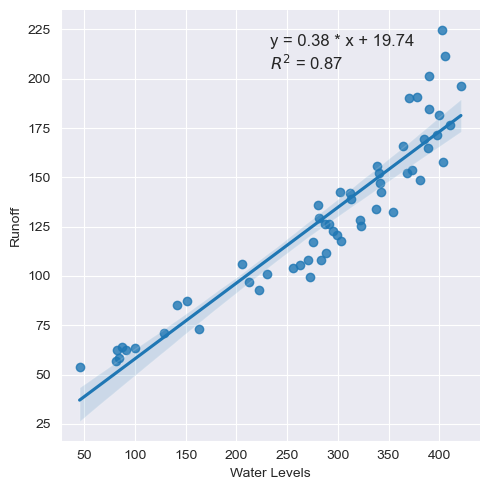

In [40]:
# X will be the water levels, and y will be the runoff
X = df_merged[['Media']]
y = df_merged['runoff_mm']

# Add a constant (intercept) to the independent variable
X = sm.add_constant(X)

# Fit a linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Get the regression coefficients (slope and intercept)
slope = model.params['Media']
intercept = model.params['const']

r_squared = model.rsquared

# Print the regression equation
equation = f"y = {slope:.2f} * x + {intercept:.2f}"
print(equation)
print(f"R-squared: {r_squared:.4f}")


# Print the summary of the regression, which includes the p-value
print(model.summary())

# Plot the scatter plot with the regression line using seaborn
sns.lmplot(x="Media", y="runoff_mm", data=df_merged, palette="Set2")
plt.xlabel('Water Levels')
plt.ylabel('Runoff')

# Add the equation and R-squared as text on the plot
plt.text(0.5, 0.9, f"{equation}\n$R^2$ = {r_squared:.2f}", ha='left', va='center',
         transform=plt.gca().transAxes, fontsize=12)

plt.show()

In [14]:
# Define the regression equation coefficients
slope = 0.38
intercept = 19.74

df2 = WL

# Calculate predicted runoff based on the regression equation
df2['Predicted_Runoff'] = slope * df2['Media'] + intercept

In [16]:
# Assuming this dataset has 'hydro_year' and 'runoff_mm' columns
actual_runoff_data = RUNOFF

# Assuming df_merged contains your data with columns "hydro_year", "Media", "Predicted_Runoff"
# Merge the predicted runoff and actual runoff data based on 'hydro_year'
df2 = df2.merge(actual_runoff_data, on='hydro_year', how='left', suffixes=('_predicted', '_actual'))

# Use predicted runoff for the years 1900 to 1964
df2.loc[df2['hydro_year'] <= 1964, 'runoff_mm'] = df2['Predicted_Runoff']

In [ ]:
df2.to_csv('Data/Runoff_Obs_Predict.csv')

In [23]:
#Comparing predicted x observed runoff data (>1965)
import METRICS

In [24]:
df2= df2[(df2["hydro_year"] >= 1965) & (df2["hydro_year"] <= 2022)]

In [34]:
df2.head()

,hydro_year,Media,Predicted_Runoff,runoff_mm
64,1965,141.000000,73.320000,85.468784
65,1966,150.916667,77.088333,87.318829
66,1967,91.083333,54.351667,62.471780
67,1968,86.666667,52.673333,63.912687
68,1969,82.083333,50.931667,62.355289


In [26]:
# Load the true values and predictions
y_true = df2['runoff_mm']
y_pred = df2['Predicted_Runoff']

# Calculate metrics
metricGENERAL = []

metricGENERAL.append({
    'r2': METRICS.R2(y_true, y_pred),
    'mae': METRICS.MAE(y_true, y_pred),
    'bias': METRICS.BIAS(y_true, y_pred),
    'mape': METRICS.MAPE(y_true, y_pred),
    'rmse': METRICS.RMSE(y_true, y_pred),
    'mae': METRICS.MAE(y_true, y_pred),
    'maelog': METRICS._maeLog_(y_true, y_pred),
    'mape': METRICS._mape_(y_true, y_pred),
    'biaslog': METRICS._biasLog_(y_true, y_pred)

})

print(metricGENERAL)

# Access the first dictionary from the list
metrics = metricGENERAL[0]



[{'r2': 0.8693780383977041, 'mae': 11.947202414999076, 'bias': 0.9897861834833886, 'mape': 9.767709916948206, 'rmse': 15.346434230644466, 'maelog': nan, 'biaslog': 0.9884960086300789}]


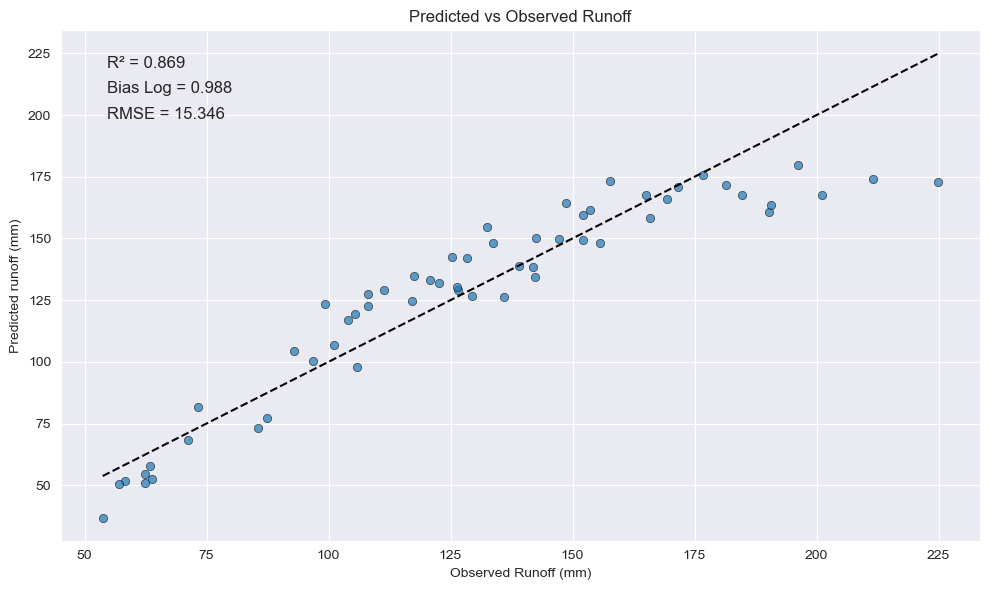

In [29]:
# Plot regression plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df2, x="runoff_mm", y="Predicted_Runoff", edgecolor="k", alpha=0.7)

# Plot ideal fit line
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='black', linestyle='--', label='Ideal fit')

# Add metrics to the plot
plt.text(0.05, 0.95, f"R² = {metrics['r2']:.3f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f"Bias Log = {metrics['biaslog']:.3f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f"RMSE = {metrics['rmse']:.3f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Customize plot labels and legend
plt.xlabel('Observed Runoff (mm)')
plt.ylabel('Predicted runoff (mm)')
plt.title('Predicted vs Observed Runoff')

plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()